In [2]:
# Imports
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import utils, transforms
from dbpn import Net as DBPN
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import warnings


current_dir = os.getcwd()

if mode == 'x2':
    model_file = '../models/DBPN_x2.pth'
    upscale_factor = 2
    train_folder = 'X2CIFAR100'
    test_folder = 'X2CIFAR100_t'
elif mode == 'x4':
    model_file = '../models/DBPN_x4.pth'
    upscale_factor = 4
    train_folder = 'X4CIFAR100'
    test_folder = 'X4CIFAR100_t'
    
    
    
model_path = os.path.join(current_dir,model_folder)
cuda = True # Set True if you're using GPU
gpus = 2
gpus_list=range(gpus)

seed = 123

if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")
    
if cuda:
    torch.cuda.manual_seed(seed)
    
print('===> Building model')
model = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=upscale_factor) ###D-DBPN
if cuda:
#     model = torch.nn.DataParallel(model, device_ids=gpus_list)
    model = model.cuda()
print('Model built')

if os.path.exists(model_path):
    dbpn_model = torch.load(model_path, map_location=lambda storage, loc: storage)
    own_state = model.state_dict()
    dbpn_list = list(dbpn_model)
    own_list = list(own_state)
    for i in range(len(dbpn_list)):
        if dbpn_list[i][7:] != own_list[i]:
            print('error')
            print(dbpn_list[i], own_list[i])
        

    for name, param in dbpn_model.items():
        name = name[7:]
        own_state[name].copy_(param)
    print('Pre-trained SR model is loaded.')
else:
    print('Directory path does not exist')
    
transform = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR100(root='/datasets/ee285s-public/', train=False, download=False, transform=transform)
testloader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=1)
test_iter = iter(testloader)

trainset = torchvision.datasets.CIFAR100(root='/datasets/ee285s-public/', train=True, download=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)
train_iter = iter(trainloader)



In [3]:
warnings.filterwarnings("ignore")


img_labels = []
for i in range(len(trainloader)):
    data = train_iter.next()
    images, labels = data
    inp = Variable(images, requires_grad = False)
    output = model(inp.cuda()).cpu().data
    
    npimg = np.array(output).squeeze()
    nplbl = np.array(labels).squeeze()
    
    img_labels.append(nplbl)
    im_path = os.path.join(current_dir, train_folder, str(i)+'.npy')
    np.save(im_path, npimg)
    
label_path = os.path.join(current_dir, train_folder, 'labels.npy')
np.save(label_path,np.array(img_labels))


img_labels = []
for i in range(len(testloader)):
    data = test_iter.next()
    images, labels = data
    inp = Variable(images, requires_grad = False)
    output = model(inp.cuda()).cpu().data
    
    npimg = np.array(output).squeeze()
    nplbl = np.array(labels).squeeze()
    
    img_labels.append(nplbl)
    im_path = os.path.join(current_dir, test_folder, str(i)+'.npy')
    np.save(im_path, npimg)
    
label_path = os.path.join(current_dir, test_folder, 'labels.npy')
np.save(label_path,np.array(img_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50000,)
(3, 64, 64)


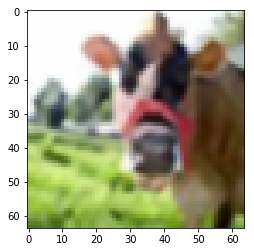

In [11]:
label_path = os.path.join(current_dir, train_folder, 'labels.npy')
labels = np.load(label_path)
print(labels.shape)
img_path = os.path.join(current_dir, train_folder, '0.npy')
img = np.load(img_path)
print(img.shape)
plt.figure()
plt.imshow(np.transpose(img, (1, 2, 0))) # Transpose is to convert from BGR to RGB
plt.show()